In [1]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
from tqdm import tqdm
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [2]:
#########################
# Augmentation methods
#########################
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=-0.5 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

####################################
# the confusion matrix heat map plot
####################################
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## **1. Explore augmentation method**

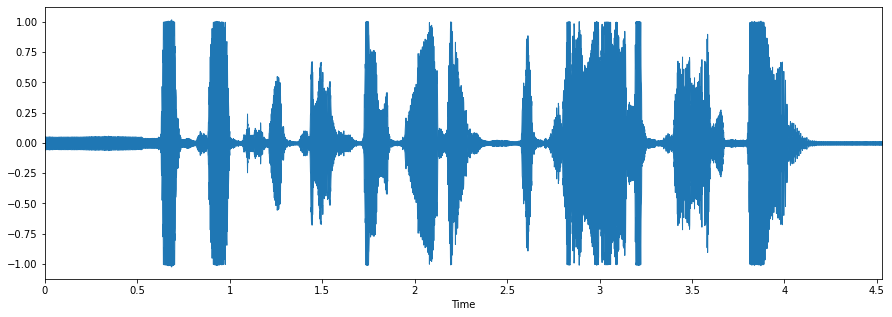

In [3]:
# Use one audio file in previous parts again
fname = './datasets/SAVEE/JK/f11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Paly it again to refresh our memory
ipd.Audio(data, rate=sampling_rate)

**Static noise**

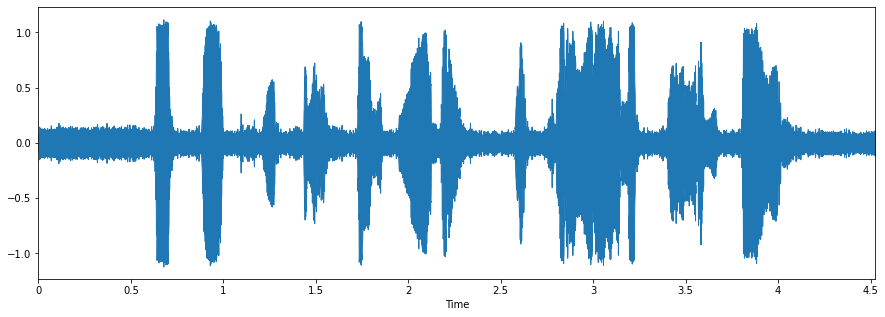

In [4]:
x = noise(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

**Shift**

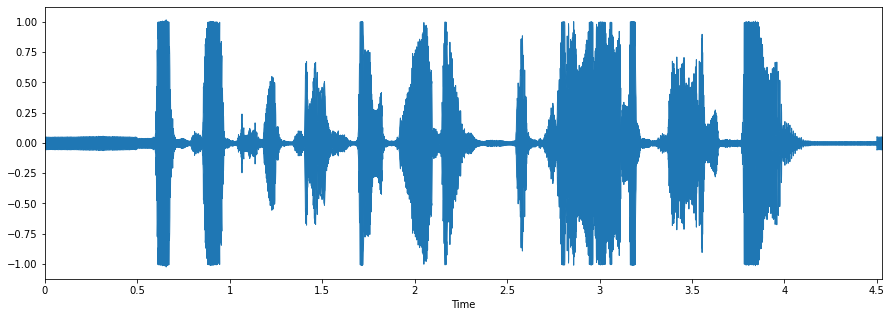

In [5]:
x = shift(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

**Stretch**

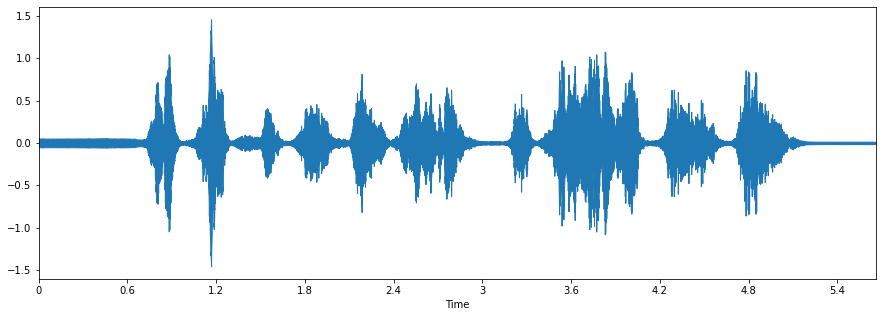

In [6]:
x = stretch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

**Pitch**

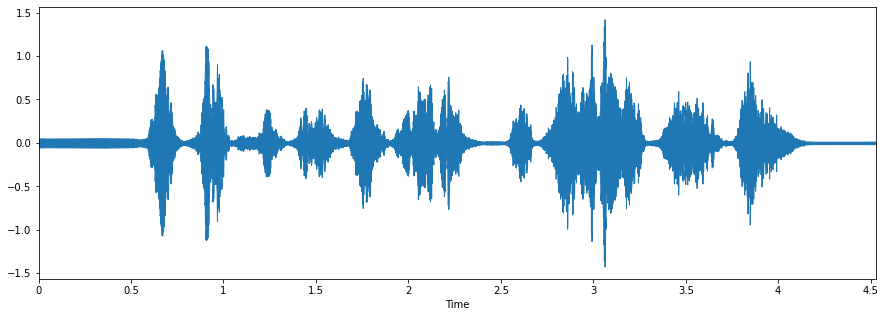

In [7]:
x = pitch(data, sampling_rate)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

**Dynamic change**

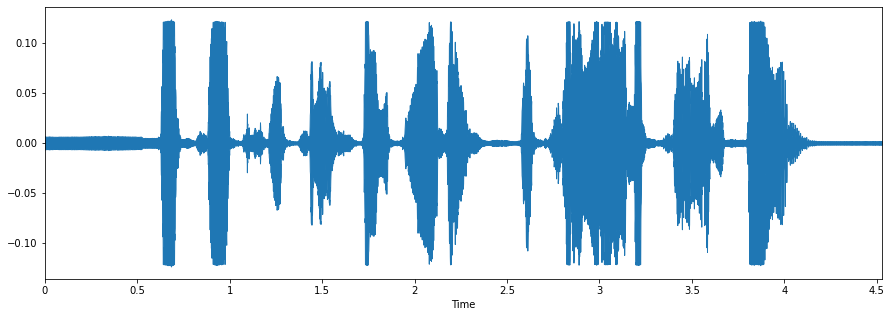

In [8]:
x = dyn_change(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

**Speed and pitch**

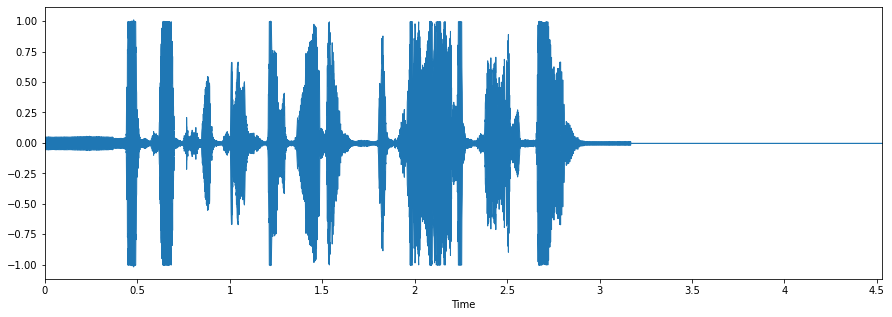

In [9]:
x = speedNpitch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

## **2. Data preparation and processing**

In [10]:
# lets pick up the meta-data that we got from our first part of the Kernel

ref = pd.read_csv("./datasets/Data_path.csv")
ref.head()

,labels,source,path
0,male_angry,SAVEE,./datasets/SAVEE/DC/a01.wav
1,male_angry,SAVEE,./datasets/SAVEE/DC/a02.wav
2,male_angry,SAVEE,./datasets/SAVEE/DC/a03.wav
3,male_angry,SAVEE,./datasets/SAVEE/DC/a04.wav
4,male_angry,SAVEE,./datasets/SAVEE/DC/a05.wav


In [11]:
# Note this takes a couple of minutes (~16 mins) as we're iterating over 4 datasets, and with augmentation  
df = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
cnt = 0

# loop feature extraction over the entire dataset
for i in tqdm(ref.path):
    
    # first load the audio 
    X, sample_rate = librosa.load(i
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )

    # take mfcc and mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=np.array(sample_rate), 
                                        n_mfcc=13),
                    axis=0)
    
    df.loc[cnt] = [mfccs]   

    # random shifting (omit for now)
    # Stretch
    # pitch (omit for now)
    # dyn change
    
    # noise 
    aug = noise(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_noise.loc[cnt] = [aug]

    # speed pitch
    aug = speedNpitch(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_speedpitch.loc[cnt] = [aug]   

    cnt += 1

df.head()

100%|██████████| 1920/1920 [03:40<00:00,  8.70it/s]


,feature
0,"[-11.113933, -7.215756, -6.21919, -5.9265423, ..."
1,"[-24.449831, -22.465742, -22.928043, -23.24380..."
2,"[-25.000114, -24.520256, -24.178183, -23.84745..."
3,"[-1.529839, -4.333437, -12.285238, -13.083024,..."
4,"[-22.458635, -22.467834, -25.884357, -27.82704..."


In [12]:
# save it
df.to_pickle('./model/myEmotionDatabases-with-augmentation')

In [13]:
# load it
df = pd.read_pickle('./model/myEmotionDatabases-with-augmentation')
df.head()

,feature
0,"[-11.113933, -7.215756, -6.21919, -5.9265423, ..."
1,"[-24.449831, -22.465742, -22.928043, -23.24380..."
2,"[-25.000114, -24.520256, -24.178183, -23.84745..."
3,"[-1.529839, -4.333437, -12.285238, -13.083024,..."
4,"[-22.458635, -22.467834, -25.884357, -27.82704..."


In [14]:
# combine 
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df_noise = pd.concat([ref,pd.DataFrame(df_noise['feature'].values.tolist())],axis=1)
df_speedpitch = pd.concat([ref,pd.DataFrame(df_speedpitch['feature'].values.tolist())],axis=1)
print(df.shape,df_noise.shape,df_speedpitch.shape)

(1920, 219) (1920, 219) (1920, 219)


In [15]:
# stacking them
df = pd.concat([df,df_noise,df_speedpitch],axis=0,sort=False)
df=df.fillna(0)
del df_noise, df_speedpitch

df.head()

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_angry,SAVEE,./datasets/SAVEE/DC/a01.wav,-11.113933,-7.215756,-6.219190,-5.926542,-5.850419,-4.808960,-2.513003,...,-4.088852,-5.023864,-5.254714,-5.234095,-5.310307,-5.621666,-6.072197,-6.611348,-2.509089,1.964608
1,male_angry,SAVEE,./datasets/SAVEE/DC/a02.wav,-24.449831,-22.465742,-22.928043,-23.243807,-22.926605,-23.432241,-14.830004,...,-22.627258,-22.633406,-22.511597,-24.300154,-24.496809,-22.895985,-23.511503,-24.342152,-24.530262,-25.457796
2,male_angry,SAVEE,./datasets/SAVEE/DC/a03.wav,-25.000114,-24.520256,-24.178183,-23.847450,-15.182783,-10.732485,-8.681472,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male_angry,SAVEE,./datasets/SAVEE/DC/a04.wav,-1.529839,-4.333437,-12.285238,-13.083024,-12.041327,-11.819768,-9.414148,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male_angry,SAVEE,./datasets/SAVEE/DC/a05.wav,-22.458635,-22.467834,-25.884357,-27.827044,-27.593534,-26.666508,-18.659023,...,-25.291666,-25.854906,-26.821354,-25.436455,-24.179941,-23.281618,-24.167494,-25.228062,-25.902941,-25.589964


In [16]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
668,-66.264893,-66.264893,-66.264893,-66.264893,-66.264893,-66.264893,-66.264893,-66.264893,-66.264893,-67.042038,...,-39.705379,-40.741112,-41.120735,-40.283394,-39.689163,-39.673252,-40.182980,-41.530998,-36.970688,-30.308891
218,-26.575468,-26.038328,-27.055674,-27.812929,-25.842054,-25.779335,-25.921089,-24.171457,-25.842537,-25.202175,...,-26.125536,-27.084093,-26.680504,-25.796246,-26.386827,-27.404705,-27.704195,-26.367107,-26.645704,-27.550621
966,-69.596954,-69.870628,-69.870628,-69.870628,-69.870628,-69.755615,-68.362808,-67.334900,-69.151192,-68.447220,...,-69.870628,-69.870628,-69.870628,-69.870628,-69.870628,-69.870628,-69.870628,-69.870628,-69.870628,-69.870628
1795,-23.288314,-23.104718,-24.156036,-23.498397,-23.443545,-24.306807,-26.422996,-24.787882,-23.144155,-23.272088,...,-24.817900,-23.878560,-23.516175,-23.774521,-24.997352,-25.573925,-26.146796,-24.327856,-23.842083,-23.562734
1088,-56.689888,-54.838646,-55.437298,-55.914169,-56.978897,-57.041958,-56.250668,-55.850483,-53.746628,-53.482845,...,-73.916092,-73.916092,-73.916092,-73.916092,-73.916092,-73.916092,-73.916092,-73.916092,-73.916092,-73.916092
844,-43.747454,-42.018583,-41.806507,-39.782844,-41.440843,-43.994486,-43.013272,-40.560675,-40.416476,-40.901979,...,-39.037347,-40.359249,-40.243633,-38.794594,-39.172541,-38.910330,-39.946730,-42.347406,-42.818390,-40.669455
367,-20.170341,-22.323254,-30.911438,-29.682356,-30.273003,-32.296650,-34.122879,-34.486534,-35.488499,-34.713169,...,-54.979027,-54.979027,-54.979027,-54.979027,-54.979027,-54.979027,-54.979027,-54.979027,-54.979027,-54.979027
585,-65.068947,-65.068947,-65.068947,-65.068947,-65.068947,-65.068947,-65.068947,-65.068947,-65.068947,-65.068947,...,-54.088650,-53.337856,-51.697556,-53.936035,-54.732964,-53.260056,-51.906754,-54.850605,-57.753029,-62.966248
1904,-60.102177,-60.102177,-60.102177,-60.102177,-60.102177,-60.102177,-60.102177,-60.102177,-60.102177,-60.102177,...,-60.102177,-60.102177,-60.102177,-60.102177,-60.102177,-60.102177,-60.102177,-60.102177,-60.102177,-60.102177
1692,-28.840283,-26.371558,-26.887547,-28.452277,-28.436761,-29.144094,-29.640550,-28.955718,-26.853717,-26.504121,...,-27.527587,-27.349665,-29.144400,-28.161295,-28.685968,-26.823062,-27.487145,-28.721778,-28.576113,-28.255712


In [17]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
668,-1.361952,-1.390135,-1.404739,-1.397025,-1.394200,-1.393673,-1.393480,-1.389971,-1.392929,-1.437478,...,-0.000242,-0.049694,-0.065558,-0.018486,0.013967,0.017987,-0.003867,-0.069028,0.140306,0.447917
218,0.834041,0.844012,0.820540,0.764486,0.858117,0.850111,0.833544,0.922874,0.827930,0.859104,...,0.692666,0.645622,0.668564,0.717887,0.690158,0.641533,0.628973,0.698141,0.651785,0.580951
966,-1.546314,-1.590394,-1.609379,-1.599715,-1.595108,-1.587135,-1.509287,-1.448763,-1.551506,-1.514608,...,-1.539414,-1.532757,-1.527164,-1.522389,-1.520233,-1.516786,-1.509426,-1.502780,-1.489494,-1.460196
1795,1.015918,1.006942,0.985106,1.007020,0.991759,0.931721,0.805838,0.889004,0.976183,0.965046,...,0.759388,0.808825,0.829434,0.820650,0.760788,0.734582,0.707954,0.801310,0.790671,0.773292
1088,-0.832173,-0.755532,-0.790230,-0.815177,-0.876795,-0.882521,-0.840683,-0.817746,-0.705159,-0.693216,...,-1.745833,-1.738723,-1.732829,-1.728018,-1.725874,-1.722396,-1.714585,-1.707448,-1.689898,-1.655313
844,-0.116075,-0.043517,-0.016628,0.091618,-0.011031,-0.159406,-0.109964,0.022360,0.027218,-0.002655,...,0.033845,-0.030252,-0.020967,0.057188,0.040228,0.056763,0.008114,-0.110331,-0.149378,-0.051786
367,1.188433,1.050344,0.601710,0.659400,0.611229,0.488910,0.380796,0.356107,0.297968,0.337048,...,-0.779575,-0.774585,-0.770095,-0.765457,-0.763256,-0.759924,-0.754224,-0.749388,-0.751793,-0.741955
585,-1.295781,-1.323713,-1.336865,-1.329797,-1.327564,-1.327392,-1.327462,-1.324259,-1.327222,-1.329175,...,-0.734144,-0.691029,-0.603269,-0.712443,-0.750748,-0.672558,-0.598418,-0.742890,-0.889211,-1.127189
1904,-1.020973,-1.047863,-1.054981,-1.050598,-1.050821,-1.052124,-1.053291,-1.051357,-1.054341,-1.056550,...,-1.040982,-1.035419,-1.030549,-1.025864,-1.023678,-1.020307,-1.014035,-1.008577,-1.005584,-0.989051
1692,0.708730,0.825505,0.830082,0.728546,0.713543,0.663630,0.628226,0.660000,0.772374,0.787641,...,0.621127,0.632101,0.543302,0.597673,0.573286,0.671095,0.639981,0.579014,0.556157,0.546944


In [18]:
# make the dataset keras compatible

# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

# Pickel the lb object for future use
outfile = open('./model/labels','wb')
pickle.dump(lb,outfile)
outfile.close()

(4320, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [19]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(4320, 216, 1)

## **3. Modelling**

In [20]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
opt = optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          2304      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 256)          524544    
                                                                 
 batch_normalization (BatchN  (None, 216, 256)         1024      
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 216, 256)          0         
                                                                 
 dropout (Dropout)           (None, 216, 256)          0         
                                                        

In [21]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_test, y_test),verbose=2)

Epoch 1/150
270/270 - 38s - loss: 2.5192 - accuracy: 0.1574 - val_loss: 2.6218 - val_accuracy: 0.0896 - 38s/epoch - 140ms/step
Epoch 2/150
270/270 - 34s - loss: 2.3365 - accuracy: 0.2088 - val_loss: 2.4907 - val_accuracy: 0.1813 - 34s/epoch - 127ms/step
Epoch 3/150
270/270 - 35s - loss: 2.2428 - accuracy: 0.2229 - val_loss: 2.3455 - val_accuracy: 0.2021 - 35s/epoch - 130ms/step
Epoch 4/150
270/270 - 38s - loss: 2.1707 - accuracy: 0.2426 - val_loss: 2.2922 - val_accuracy: 0.2347 - 38s/epoch - 141ms/step
Epoch 5/150
270/270 - 37s - loss: 2.1238 - accuracy: 0.2634 - val_loss: 2.2462 - val_accuracy: 0.2375 - 37s/epoch - 136ms/step
Epoch 6/150
270/270 - 37s - loss: 2.0783 - accuracy: 0.2799 - val_loss: 2.2189 - val_accuracy: 0.2438 - 37s/epoch - 135ms/step
Epoch 7/150
270/270 - 37s - loss: 2.0290 - accuracy: 0.2896 - val_loss: 2.1886 - val_accuracy: 0.2618 - 37s/epoch - 136ms/step
Epoch 8/150
270/270 - 35s - loss: 1.9896 - accuracy: 0.2993 - val_loss: 2.1484 - val_accuracy: 0.2646 - 35s/epo

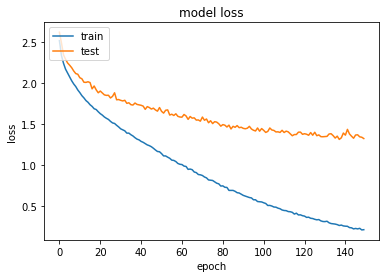

In [22]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **4. Model serialisation**

In [25]:
# Save model and weights
model_name = 'SER_Model_1D_aug.h5'
save_dir = './model/'

model_path = save_dir + model_name
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("./model/model_json_1D_aug.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at ./model/SER_Model_1D_aug.h5 


## **5. Model validation**

In [26]:
# loading json and model architecture 
json_file = open('./model/model_json_1D_aug.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("./model/SER_Model_1D_aug.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 54.10%


In [27]:
# run it through the test set.
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

90/90 [==============================] - 3s 32ms/step


array([ 4, 12,  7, ..., 11, 11,  3], dtype=int64)

In [28]:
# append the labels to it before we run the accuracy measure

# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_disgust,male_neutral
171,male_sad,female_disgust
172,male_neutral,male_neutral
173,male_happy,male_happy
174,female_angry,male_fear
175,male_surprise,male_surprise
176,male_neutral,male_neutral
177,female_surprise,female_happy
178,male_sad,male_sad
179,male_sad,male_surprise


In [29]:
# Write out the predictions to disk
finaldf.to_csv('./model/Predictions_aug.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,95
female_disgust,82
female_fear,90
female_happy,87
female_neutral,112
female_sad,64
female_surprise,58
male_angry,95
male_disgust,105


**Emotion by gender accuracy**

0.5409722222222222


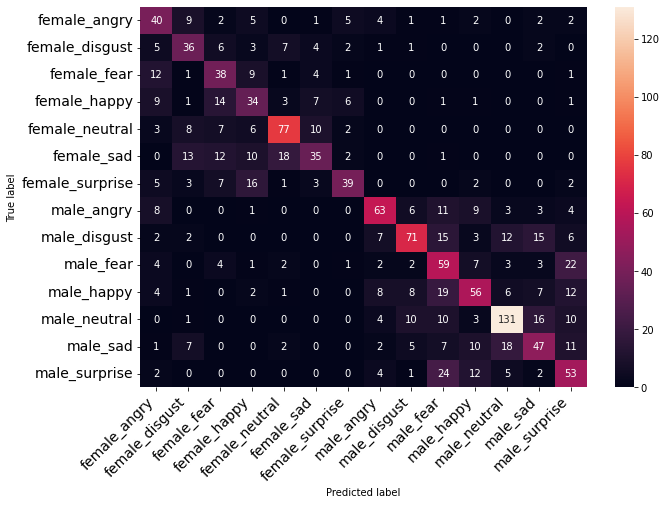

In [30]:
# Get the predictions file 
finaldf = pd.read_csv("./model/Predictions_aug.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [31]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.42      0.54      0.47        74
 female_disgust       0.44      0.54      0.48        67
    female_fear       0.42      0.57      0.48        67
   female_happy       0.39      0.44      0.41        77
 female_neutral       0.69      0.68      0.68       113
     female_sad       0.55      0.38      0.45        91
female_surprise       0.67      0.50      0.57        78
     male_angry       0.66      0.58      0.62       108
   male_disgust       0.68      0.53      0.60       133
      male_fear       0.40      0.54      0.46       110
     male_happy       0.53      0.45      0.49       124
   male_neutral       0.74      0.71      0.72       185
       male_sad       0.48      0.43      0.45       110
  male_surprise       0.43      0.51      0.47       103

       accuracy                           0.54      1440
      macro avg       0.54      0.53      0.53      1440
   weighted avg       0.56   

**Gender accuracy result**

0.9506944444444444


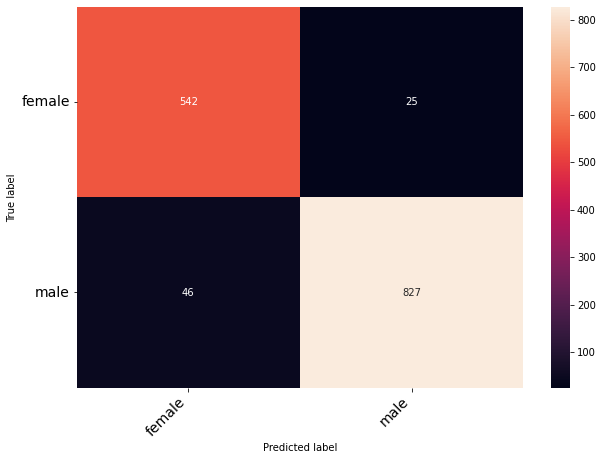

In [32]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [33]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.92      0.96      0.94       567
        male       0.97      0.95      0.96       873

    accuracy                           0.95      1440
   macro avg       0.95      0.95      0.95      1440
weighted avg       0.95      0.95      0.95      1440



**Emotion accuracy**

0.9506944444444444


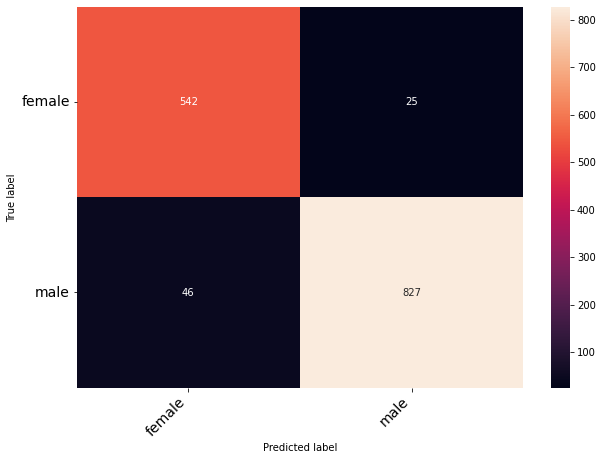

In [34]:
modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [35]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.92      0.96      0.94       567
        male       0.97      0.95      0.96       873

    accuracy                           0.95      1440
   macro avg       0.95      0.95      0.95      1440
weighted avg       0.95      0.95      0.95      1440

